# Purpose
The purpose of this notebook is to load the data source and build a vector store.

# Data Source
The reddit financial dataset from HuggingFace will be used as the data source for this project.  Information available [here](https://huggingface.co/datasets/winddude/reddit_finance_43_250k). 

In [1]:
from datasets import load_dataset

df_data = (
    load_dataset("winddude/reddit_finance_43_250k", split="train")
    .to_pandas()
    .sort_values(by="combined_score", ascending=False)
)

df_data["text"] = df_data["title"] + "/n/n" + df_data["selftext"] + "/n/n" + df_data["body"]
df_data["text_len"] = df_data.text.str.len()

/Users/mcnewcp/code/contextual-qa-chat-app/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## EDA

It looks like some of the text strings are very long, though the majority are <2,000 characters.  For this simple example, I don't want to spend extra effort on splitting strategies or a summarization task on the longer texts, I'll simply filter down to those with 1,000 characters or less.  Text of this size should not need to be split when converted to vector documents.  I'll also choose the "best" 5,000 options as scored by `combined_score`.

<Axes: >

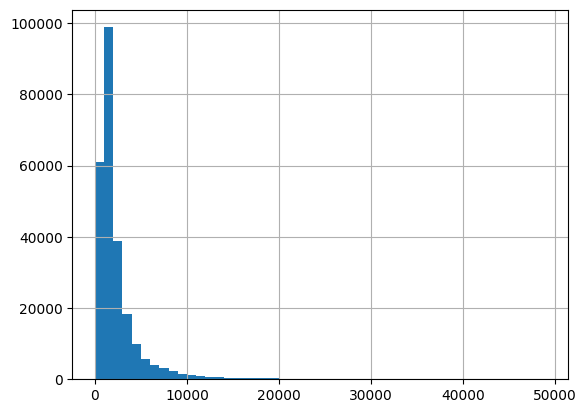

In [2]:
df_data["text_len"].hist(bins = range(0, 50000, 1000))

In [4]:
df_data = (
    df_data
    .query("text_len <= 1000")
    .iloc[0:5000]
    .loc[:,["id", "text"]]
)

# Indexed Vectors

## Generate Documents
Langchain provides many different [document loaders](https://integrations.langchain.com).

In [7]:
from langchain.document_loaders import DataFrameLoader

loader = DataFrameLoader(df_data, page_content_column="text")
docs = loader.load()

## Embed and Store
Now I'll embed using [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) and index in a [FAISS](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.faiss.FAISS.html) vectorstore.

In [28]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

db = FAISS.from_documents(docs, embeddings)
db.save_local("data/vector-db")

# 